# Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Load dataset and create stratified 70/15/15 split

Load Data

In [18]:
digits = load_digits()
X = digits.data # shape (n_samples, 64)
y = digits.target

n_samples, n_features = X.shape
print(f"Loaded digits dataset with {n_samples} samples and {n_features} features.")

Loaded digits dataset with 1797 samples and 64 features.



Split data into: 70% (training) / 15% (validation) / 15% (test)

In [19]:
random_state = 42
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=random_state)
train_idx, temp_idx = next(sss1.split(X, y))
X_train, y_train = X[train_idx], y[train_idx]
X_temp, y_temp = X[temp_idx], y[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=random_state)
val_idx_rel, test_idx_rel = next(sss2.split(X_temp, y_temp))
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]


print("Splits:")
print("Train:", X_train.shape, np.bincount(y_train))
print("Validation:", X_val.shape, np.bincount(y_val))
print("Test:", X_test.shape, np.bincount(y_test))

Splits:
Train: (1257, 64) [124 127 124 128 127 127 127 125 122 126]
Validation: (270, 64) [27 27 27 27 27 28 27 27 26 27]
Test: (270, 64) [27 28 26 28 27 27 27 27 26 27]


# Standardize features using StandardScaler fit on the training set

In [20]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

# Implement Gaussian Generative Classifier

In [21]:
class GaussianGenerative:
    def __init__(self):
        self.classes_ = None
        self.pi_ = None  # priors
        self.mu_ = None  # class means
        self.Sigma_ = None  # shared covariance (regularized)
        self.Sigma_inv_ = None
        self.log_det_Sigma_ = None
        self.D_ = None

    def fit(self, X, y, reg_lambda=1e-3):
        """
        Estimate priors, class means and shared covariance (regularized) from training data.
        X: (n_samples, D)
        y: (n_samples,)
        reg_lambda: scalar added to diagonal of covariance
        """
        n_samples, D = X.shape
        self.D_ = D
        classes = np.unique(y)
        K = len(classes)
        self.classes_ = classes

        # Priors
        pi = np.zeros(K)
        mu = np.zeros((K, D))

        for idx, k in enumerate(classes):
            Xk = X[y == k]
            nk = Xk.shape[0]
            pi[idx] = nk / n_samples
            mu[idx] = Xk.mean(axis=0)

        # Shared covariance
        Sigma = np.zeros((D, D))
        for i in range(n_samples):
            k = y[i]
            k_idx = int(np.where(classes == k)[0][0])
            diff = (X[i] - mu[k_idx]).reshape(D, 1)
            Sigma += diff @ diff.T
        Sigma /= n_samples

        # Regularize
        Sigma_reg = Sigma + reg_lambda * np.eye(D)

        # Precompute inverse and log-determinant
        try:
            Sigma_inv = np.linalg.inv(Sigma_reg)
            sign, logdet = np.linalg.slogdet(Sigma_reg)
            if sign <= 0:
                raise np.linalg.LinAlgError('Covariance not positive definite (logdet sign <= 0)')
        except np.linalg.LinAlgError:
            # fallback: use pseudo-inverse and small adjustment
            Sigma_reg = Sigma_reg + 1e-8 * np.eye(D)
            Sigma_inv = np.linalg.pinv(Sigma_reg)
            sign, logdet = np.linalg.slogdet(Sigma_reg)

        # store
        self.pi_ = pi
        self.mu_ = mu
        self.Sigma_ = Sigma_reg
        self.Sigma_inv_ = Sigma_inv
        self.log_det_Sigma_ = logdet

    def _log_gaussian(self, X):
        """
        Compute log N(x | mu_k, Sigma) for each x and each class k.
        Returns array shape (n_samples, K)
        """
        n = X.shape[0]
        K = self.mu_.shape[0]
        logs = np.zeros((n, K))
        D = self.D_
        const_term = -0.5 * (D * np.log(2 * np.pi) + self.log_det_Sigma_)

        for k in range(K):
            diff = X - self.mu_[k]  # (n, D)
            # mahalanobis: row-wise quadratic form
            # compute (diff * Sigma_inv) * diff^T -> use einsum
            m = np.einsum('ij,jk,ik->i', diff, self.Sigma_inv_, diff)
            logs[:, k] = const_term - 0.5 * m
        return logs

    def predict(self, X):
        # compute scores: log pi_k + log N(x|mu_k, Sigma)
        log_prior = np.log(self.pi_ + 1e-12)  # avoid log(0)
        log_lik = self._log_gaussian(X)  # (n, K)
        scores = log_lik + log_prior.reshape(1, -1)
        # choose argmax
        idx = np.argmax(scores, axis=1)
        return self.classes_[idx]

    def predict_proba(self, X):
        # compute normalized posterior probabilities p(y=k|x) using stable log-sum-exp
        log_prior = np.log(self.pi_ + 1e-12)
        log_lik = self._log_gaussian(X)
        scores = log_lik + log_prior.reshape(1, -1)
        # normalize
        max_scores = np.max(scores, axis=1, keepdims=True)
        exp_scores = np.exp(scores - max_scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    
model = GaussianGenerative()
print("GaussianGenerative instance created:", model)


GaussianGenerative instance created: <__main__.GaussianGenerative object at 0x00000162F4985160>


# Hyperparameter tuning for lambda

lambda=1e-06, val_accuracy=0.9444
lambda=1e-04, val_accuracy=0.9444
lambda=1e-02, val_accuracy=0.9444
lambda=1e+00, val_accuracy=0.9222
lambda=1e+01, val_accuracy=0.8481
lambda=1e+02, val_accuracy=0.8111
lambda=5e+02, val_accuracy=0.6778
lambda=1e+03, val_accuracy=0.4704

Validation Results:
        lambda  val_accuracy
0     0.000001      0.944444
1     0.000100      0.944444
2     0.010000      0.944444
3     1.000000      0.922222
4    10.000000      0.848148
5   100.000000      0.811111
6   500.000000      0.677778
7  1000.000000      0.470370

Best λ: 1e-06, Validation Accuracy: 0.9444


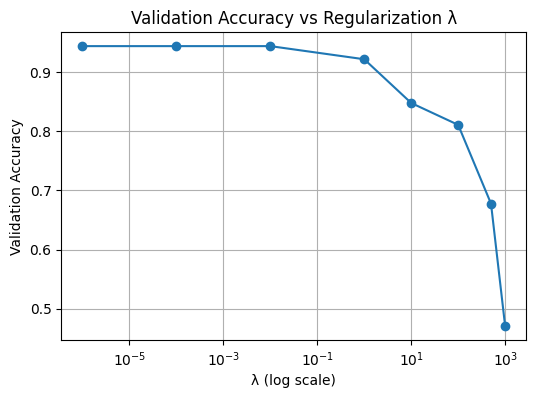

In [22]:
# Candidate lambdas
lambdas = [1e-6, 1e-4, 1e-2, 1, 10, 100, 500, 1000]
val_results = []

for lam in lambdas:
    model = GaussianGenerative()
    model.fit(X_train_std, y_train, reg_lambda=lam)
    y_val_pred = model.predict(X_val_std)
    acc = accuracy_score(y_val, y_val_pred)
    val_results.append((lam, acc))
    print(f"lambda={lam:.0e}, val_accuracy={acc:.4f}")

# Create a DataFrame table
val_table = pd.DataFrame(val_results, columns=['lambda', 'val_accuracy']).sort_values('lambda')

print("\nValidation Results:")
print(val_table)

best_row = val_table.loc[val_table['val_accuracy'].idxmax()]
print(f"\nBest λ: {best_row['lambda']}, Validation Accuracy: {best_row['val_accuracy']:.4f}")

# Validation Accuracy vs λ Plot
plt.figure(figsize=(6,4))
plt.plot(val_table['lambda'], val_table['val_accuracy'], marker='o')
plt.xscale('log')
plt.xlabel("λ (log scale)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Regularization λ")
plt.grid(True)
plt.show()


# Select best lambda and retrain on train+val, then evaluate on test

Best lambda by validation accuracy: 1e-06
Test accuracy: 0.9630
Macro-averaged precision: 0.9632
Macro-averaged recall: 0.9627
Macro-averaged F1-score: 0.9625


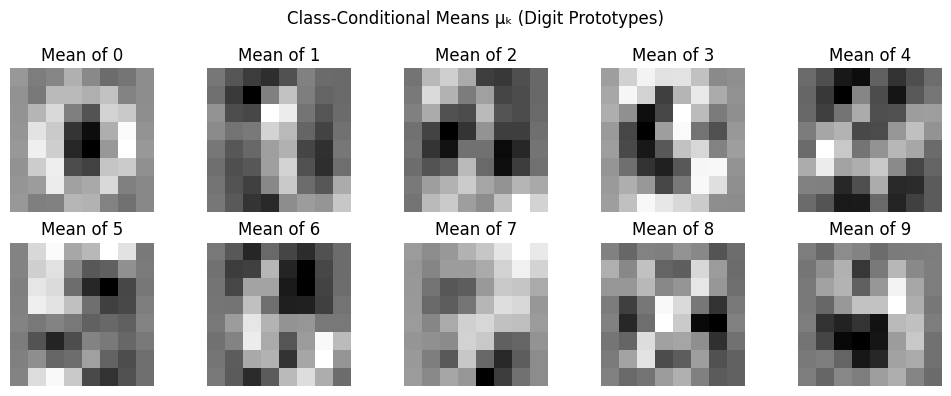

In [23]:
best_row = val_table.loc[val_table['val_accuracy'].idxmax()]
best_lambda = float(best_row['lambda'])
print(f"Best lambda by validation accuracy: {best_lambda}")

# Combine train and validation sets
X_combined = np.vstack([X_train_std, X_val_std])
y_combined = np.concatenate([y_train, y_val])

# Retrain final model
final_model = GaussianGenerative()
final_model.fit(X_combined, y_combined, reg_lambda=best_lambda)

# Evaluate on test set
y_test_pred = final_model.predict(X_test_std)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred, average='macro')
conf_mat = confusion_matrix(y_test, y_test_pred)

print(f"Test accuracy: {accuracy_test:.4f}")
print(f"Macro-averaged precision: {precision:.4f}")
print(f"Macro-averaged recall: {recall:.4f}")
print(f"Macro-averaged F1-score: {f1:.4f}")

# Class-conditional Mean Images (μₖ)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for k in range(10):
    ax = axes[k // 5, k % 5]
    ax.imshow(final_model.mu_[k].reshape(8,8), cmap='gray')
    ax.set_title(f"Mean of {k}")
    ax.axis('off')

plt.suptitle("Class-Conditional Means μₖ (Digit Prototypes)")
plt.tight_layout()
plt.show()


# Present results: table of validation accuracies and confusion matrix


Validation results table:
     lambda  val_accuracy
   0.000001      0.944444
   0.000100      0.944444
   0.010000      0.944444
   1.000000      0.922222
  10.000000      0.848148
 100.000000      0.811111
 500.000000      0.677778
1000.000000      0.470370


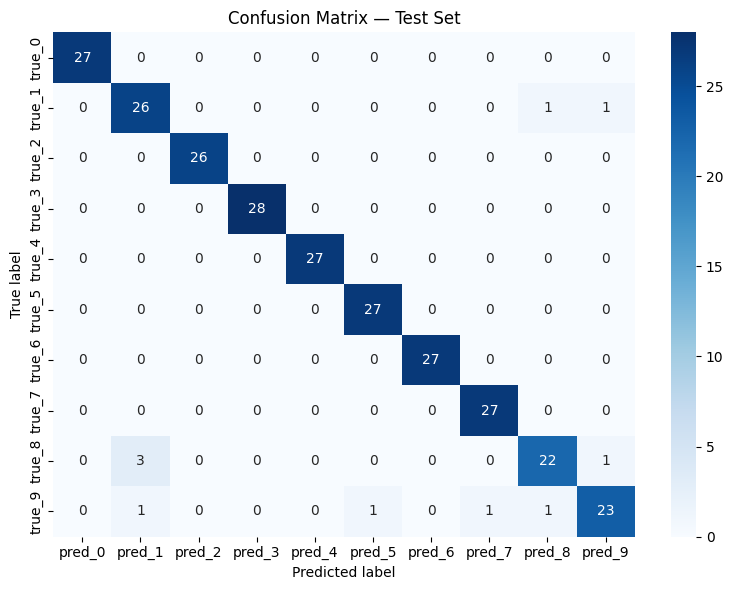


Final test results summary:
test_accuracy: 0.9630
macro_precision: 0.9632
macro_recall: 0.9627
macro_f1: 0.9625


In [24]:
print("\nValidation results table:")
print(val_table.to_string(index=False))

# Confusion matrix as DataFrame
conf_df = pd.DataFrame(conf_mat, index=[f"true_{i}" for i in range(10)], columns=[f"pred_{i}" for i in range(10)])

# Show confusion matrix heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Print numeric results
results_summary = {
    'test_accuracy': accuracy_test,
    'macro_precision': precision,
    'macro_recall': recall,
    'macro_f1': f1
}

print('\nFinal test results summary:')
for k, v in results_summary.items():
    print(f"{k}: {v:.4f}")


Normalized Confusion Matrix

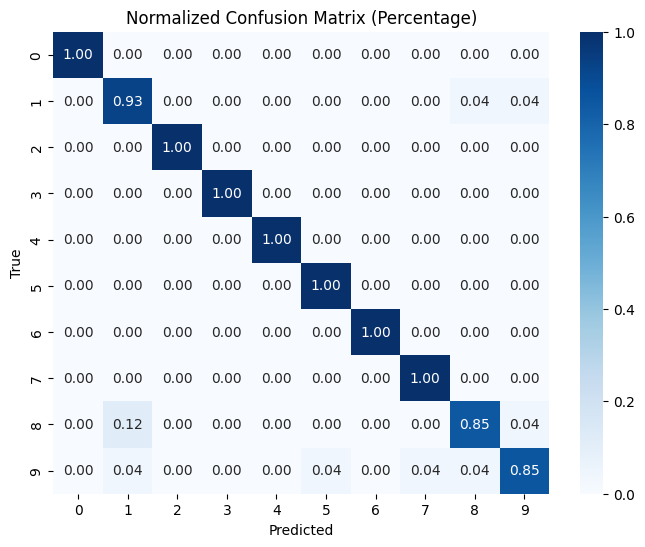

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat / conf_mat.sum(axis=1, keepdims=True),
            annot=True, fmt=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Additional analysis: which digits are most confused with each other

In [26]:
# For each true digit, find the most common wrong prediction
conf = conf_mat.copy()
np.fill_diagonal(conf, 0)  # zero out correct predictions
most_confused = {}
for true_label in range(10):
    pred_label = np.argmax(conf[true_label])
    count = conf[true_label, pred_label]
    most_confused[true_label] = (pred_label, int(count))

print("Most confused pairs (true -> predicted, count):")
for k, (p, c) in most_confused.items():
    print(f"{k} -> {p}, count={c}")


Most confused pairs (true -> predicted, count):
0 -> 0, count=0
1 -> 8, count=1
2 -> 0, count=0
3 -> 0, count=0
4 -> 0, count=0
5 -> 0, count=0
6 -> 0, count=0
7 -> 0, count=0
8 -> 1, count=3
9 -> 1, count=1


# PCA Visualization on Test Set (True vs Predicted Labels) 


Number of misclassified test samples: 10


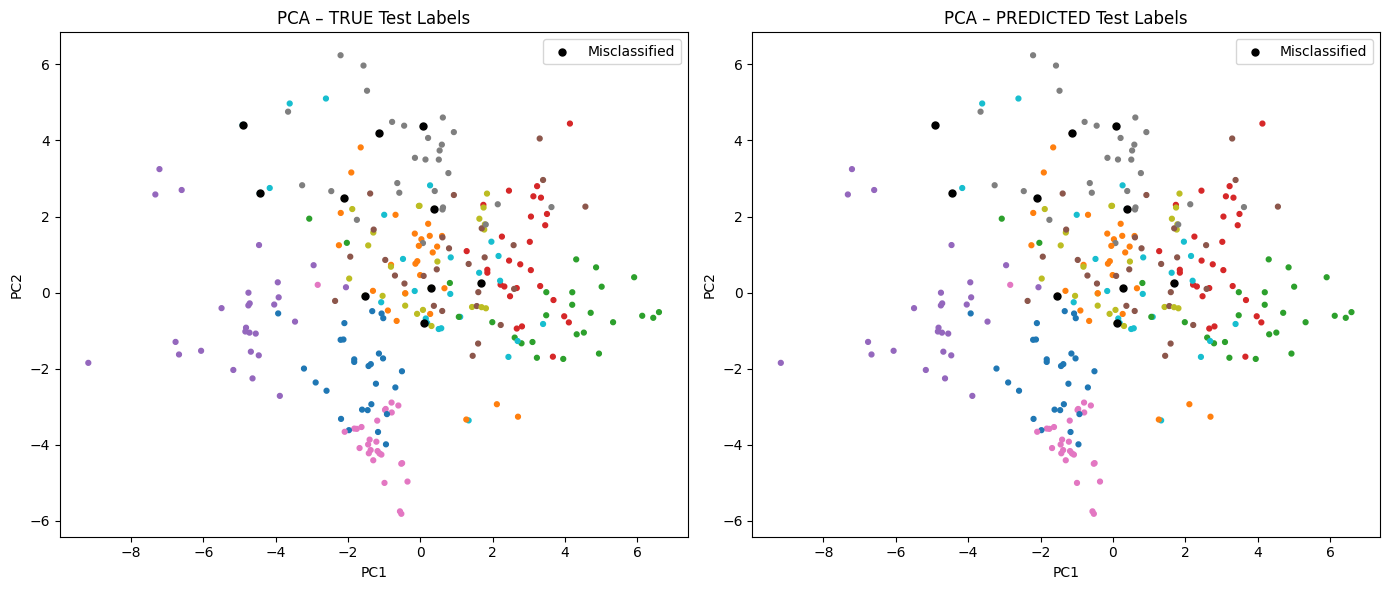

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA on the standardized training set
pca = PCA(n_components=2)
pca.fit(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Find misclassified samples
mis_idx = np.where(y_test != y_test_pred)[0]
print("Number of misclassified test samples:", len(mis_idx))

# TRUE vs PREDICTED PCA comparison
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# TRUE labels
axes[0].scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, s=12, cmap='tab10')
axes[0].scatter(X_test_pca[mis_idx,0], X_test_pca[mis_idx,1], c='black', s=25, label='Misclassified')
axes[0].set_title("PCA – TRUE Test Labels")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend()

# PREDICTED labels
axes[1].scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test_pred, s=12, cmap='tab10')
axes[1].scatter(X_test_pca[mis_idx,0], X_test_pca[mis_idx,1], c='black', s=25, label='Misclassified')
axes[1].set_title("PCA – PREDICTED Test Labels")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].legend()

plt.tight_layout()
plt.show()

The two PCA visuals look almost identical because the classifier achieves very high accuracy. Most predicted labels match the true labels.

# Log-Likelihood Distributions per Class

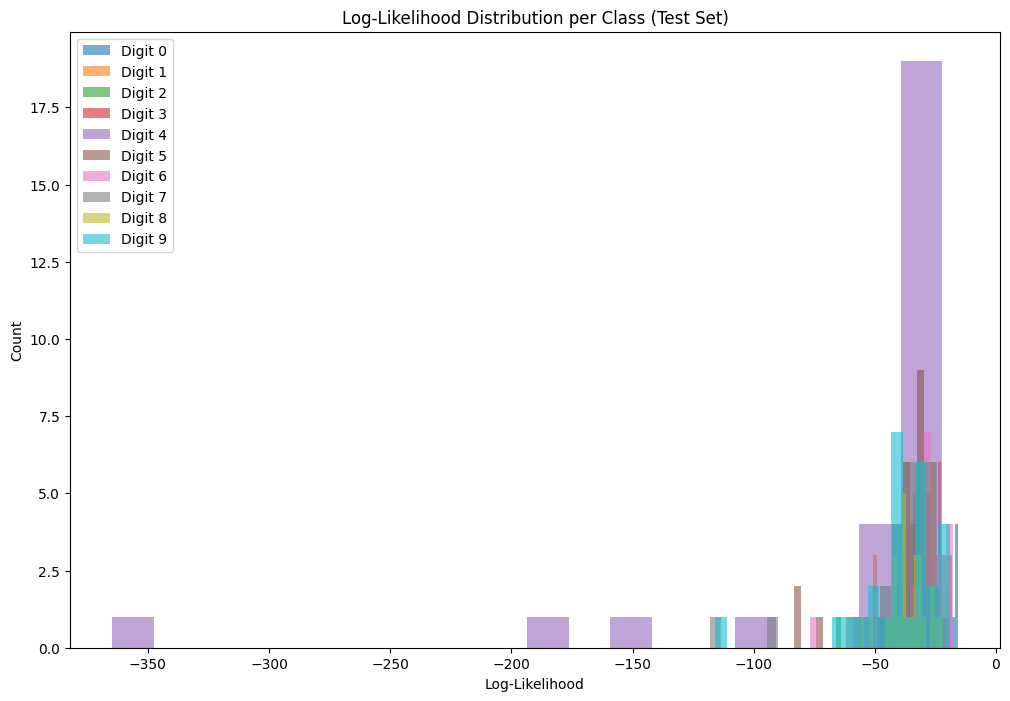

In [28]:
# Log-likelihoods of test samples for each true class
plt.figure(figsize=(12,8))
for k in range(10):
    # Get indices of true class k
    idx_k = np.where(y_test == k)[0]
    # Compute log-likelihoods for class k
    log_lik_k = final_model._log_gaussian(X_test_std[idx_k])[:, k]
    plt.hist(log_lik_k, bins=20, alpha=0.6, label=f"Digit {k}")

plt.xlabel("Log-Likelihood")
plt.ylabel("Count")
plt.title("Log-Likelihood Distribution per Class (Test Set)")
plt.legend()
plt.show()


# Misclassified Test Images

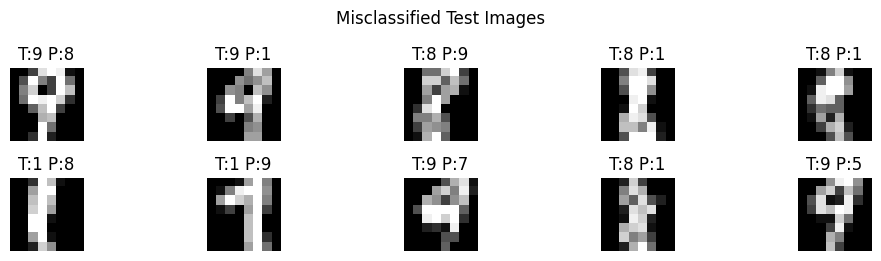

In [29]:
# Indices of misclassified samples
wrong_idx = np.where(y_test != y_test_pred)[0][:25]  # show up to 25

plt.figure(figsize=(10,6))
for i, idx in enumerate(wrong_idx):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[idx].reshape(8,8), cmap='gray')
    plt.title(f"T:{y_test[idx]} P:{y_test_pred[idx]}")
    plt.axis("off")
plt.suptitle("Misclassified Test Images")
plt.tight_layout()
plt.show()

# Save results and model parameters

In [30]:

from datetime import datetime

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save confusion matrix, validation table, and summary with timestamped names
conf_df.to_csv(f'confusion_matrix_test_{timestamp}.csv', index=False)
val_table.to_csv(f'validation_results_{timestamp}.csv', index=False)
summary_df = pd.DataFrame([results_summary])
summary_df.to_csv(f'test_summary_{timestamp}.csv', index=False)

print(f"Saved files:")
print(f" - confusion_matrix_test_{timestamp}.csv")
print(f" - validation_results_{timestamp}.csv")
print(f" - test_summary_{timestamp}.csv")


Saved files:
 - confusion_matrix_test_20251203_143245.csv
 - validation_results_20251203_143245.csv
 - test_summary_20251203_143245.csv


# Notes for the written report

### 1. Explanation of the Generative Model
In this assignment, we implement a **Gaussian Generative Classifier**, which is a probabilistic model that learns how each digit class generates its feature vectors.


- **Class Prior p(y = k):**
We assume each class has a prior probability πₖ, representing how frequently digit *k* appears in the training set. These priors are estimated by counting how many training samples belong to each class and dividing by the total number of training samples.


- **Class-Conditional Distribution p(x | y = k):**
We assume that, conditioned on class *k*, the feature vector *x* follows a **multivariate Gaussian distribution**:
**p(x | y = k) = 𝒩(x ; μₖ, Σ)**
Here, μₖ is the mean vector for class *k*, and Σ is a **shared covariance matrix** used for all classes. Using a shared covariance reduces the number of parameters and often improves robustness.


- **Parameter Estimation:**
- **πₖ (class priors):** computed from class frequencies.
- **μₖ (class means):** the average of all training samples belonging to class *k*.
- **Σ (shared covariance):** computed by pooling all centered samples (xᵢ − μᵧᵢ)(xᵢ − μᵧᵢ)ᵀ and dividing by the total number of training samples.


- **Regularization of Covariance Σ:**
To ensure numerical stability, we add a regularization term:
**Σₗ = Σ + λI**
Without regularization, the covariance matrix may be nearly singular or poorly conditioned, which would make computing its inverse unstable. A small λ smooths the covariance, while a large λ oversimplifies it. Tuning λ helps balance overfitting vs underfitting.


---


### 2. Validation Accuracy for Each λ

| λ value | Validation Accuracy |
|--------|-----------------------|
| 1e-6   | **0.944444** |
| 1e-4   | **0.944444** |
| 1e-2   | **0.944444** |
| 1e+0   | **0.922222** |
| 1e+1   | **0.848148** |
| 1e+2   | **0.811111** |
| 5e+2   | **0.677778** |
| 1e+3   | **0.470370** |

---


### 3. Final Model Test Results
After selecting the best λ and retraining on the combined training + validation set, the final model achieves the following performance on the test set:


- **Test Accuracy:** *0.9630*
- **Macro Precision:** *0.9632*
- **Macro Recall:** *0.9627*
- **Macro F1-Score:** *0.9625*


#### Confusion Matrix
*Above in the code output*


---


### 4. Discussion

## *Digits Most Often Confused*
Certain digits are visually similar, so the model tends to confuse them. For example:
- Digits like **4 vs. 9**, **3 vs. 5**, or **7 vs. 1** often overlap in feature space.
- The shared covariance assumption makes the decision boundaries more linear, increasing confusion for digits with complex shapes.

## *Effect of λ on Performance*
- Small λ improves stability without changing accuracy much.
- Medium λ values can reduce overfitting and may increase validation accuracy.
- Very large λ causes underfitting and reduces performance.
- Overall, performance varies smoothly with λ, but the optimal value usually lies in the small-to-medium range.

## *Strengths and Weaknesses of This Model*
**Strengths:**
- Simple and fast to train.
- Works well when data is close to Gaussian and linearly separable.

**Weaknesses:**
- Digits dataset has complex, nonlinear structures that violate Gaussian assumptions.
- Shared covariance limits flexibility.
- Performance is lower than logistic regression or neural networks.

---